<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/ResNet_TripletLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import random

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
val_data = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)
test_data = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.loss_fn = nn.TripletMarginLoss(margin=self.margin)

    def forward(self, anchor, positive, negative):
        return self.loss_fn(anchor, positive, negative)

In [ ]:
class TripletDataset(Dataset):
    def __init__(self, dataset):

        self.dataset = dataset
        self.labels = [label for _, label in dataset]


        self.label_to_indices = {label: [] for label in set(self.labels)}
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)

    def __getitem__(self, index):


        anchor, anchor_label = self.dataset[index]


        positive_index = index
        while positive_index == index:
            positive_index = random.choice(self.label_to_indices[anchor_label])
        positive, _ = self.dataset[positive_index]


        negative_label = random.choice(list(self.label_to_indices.keys()))
        while negative_label == anchor_label:
            negative_label = random.choice(list(self.label_to_indices.keys()))
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative, _ = self.dataset[negative_index]

        return anchor, positive, negative

    def __len__(self):
        return len(self.dataset)

In [ ]:
class ResNet18Triplet(nn.Module):
    def __init__(self):
        super(ResNet18Triplet, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(512, 128)

    def forward(self, x):
        return self.resnet18(x)

In [ ]:
train_triplet_dataset = TripletDataset(train_data)
train_loader = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)

In [ ]:
val_triplet_dataset = TripletDataset(val_data)
val_loader = DataLoader(val_triplet_dataset, batch_size=32, shuffle=False)

In [ ]:
test_triplet_dataset = TripletDataset(test_data)
test_loader = DataLoader(test_triplet_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18Triplet().to(device)

In [ ]:
triplet_criterion = TripletLoss(margin=1.0)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model_triplet(model, criterion, optimizer, num_epochs=100, patience=5):
    best_val_acc = 0.0
    counter = 0
    device = next(model.parameters()).device


    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0


        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            optimizer.zero_grad()
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            loss = criterion(anchor_output, positive_output, negative_output)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            dist_pos = (anchor_output - positive_output).pow(2).sum(1)
            dist_neg = (anchor_output - negative_output).pow(2).sum(1)
            correct_train += (dist_pos < dist_neg).sum().item()
            total_train += anchor.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)


        val_loss, val_acc = validate_model_triplet(model, criterion, device)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)


        print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            torch.save(best_model_state, 'Best_ResNet_TripletLoss.pth')  # Save model
            counter = 0
        else:
            counter += 1


        if counter >= patience:
            print(f"Early stopping at epoch {epoch}. No improvement in validation accuracy for {patience} consecutive epochs.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [ ]:
def validate_model_triplet(model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for anchor, positive, negative in val_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            loss = criterion(anchor_output, positive_output, negative_output)
            running_loss += loss.item()


            dist_pos = (anchor_output - positive_output).pow(2).sum(1)
            dist_neg = (anchor_output - negative_output).pow(2).sum(1)
            correct_val += (dist_pos < dist_neg).sum().item()
            total_val += anchor.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct_val / total_val
    return val_loss, val_acc

In [ ]:
def test_model_triplet(model):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for anchor, positive, negative in test_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)



            dist_pos = (anchor_output - positive_output).pow(2).sum(1)
            dist_neg = (anchor_output - negative_output).pow(2).sum(1)
            correct += (dist_pos < dist_neg).sum().item()
            total+= anchor.size(0)

    test_acc = correct / total
    return test_acc

In [ ]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history=train_model_triplet(model, triplet_criterion, optimizer, num_epochs=100)

Epoch [1/100], Train Loss: 0.6676, Train Accuracy: 0.8127, Validation Loss: 1.3563, Validation Accuracy: 0.7696
Epoch [2/100], Train Loss: 0.6194, Train Accuracy: 0.7843, Validation Loss: 0.5759, Validation Accuracy: 0.7941
Epoch [3/100], Train Loss: 0.5355, Train Accuracy: 0.7912, Validation Loss: 0.6525, Validation Accuracy: 0.7676
Epoch [4/100], Train Loss: 0.5962, Train Accuracy: 0.7657, Validation Loss: 0.5707, Validation Accuracy: 0.7755
Epoch [5/100], Train Loss: 0.4833, Train Accuracy: 0.8039, Validation Loss: 0.5293, Validation Accuracy: 0.7882
Epoch [6/100], Train Loss: 0.5161, Train Accuracy: 0.8010, Validation Loss: 0.5583, Validation Accuracy: 0.7853
Epoch [7/100], Train Loss: 0.5093, Train Accuracy: 0.7980, Validation Loss: 0.5503, Validation Accuracy: 0.7941
Early stopping at epoch 7. No improvement in validation accuracy for 5 consecutive epochs.


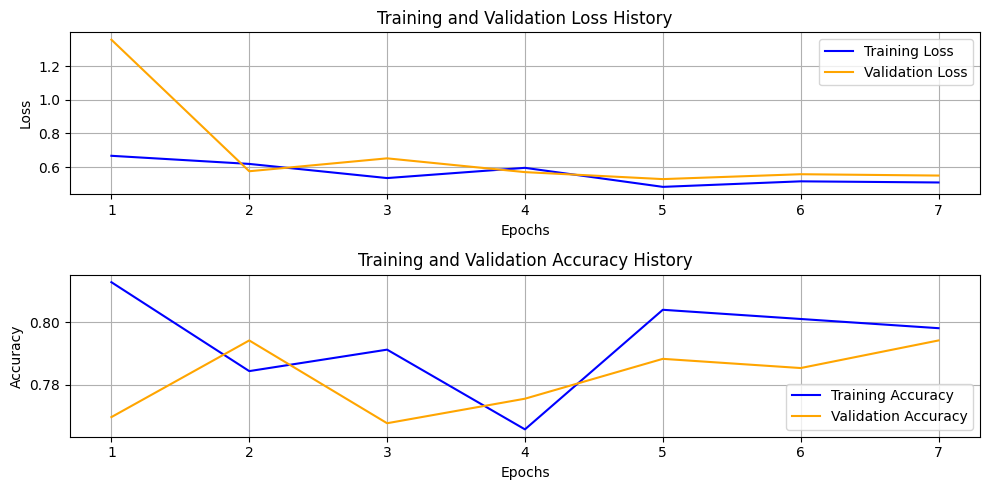

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
test_acc=test_model_triplet(model)

In [ ]:
print(f'Test Accuracy: {test_acc}%')

Test Accuracy: 0.7754106358757522%
